In [1]:
import torch
import os
import csv
import math
import numpy as np

In [2]:
import sys
import os
here = os.getcwd()
sys.path.append(os.path.join(here,"../"))

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from models.cde.cde_data_common import process_data,get_final_linear_input_channels,get_final_indices,wrap_data,augment_data
import models.cde.cde_train_common as train_common

from utils.test_utils import make_results_filenames

#from explainer.integrad import integrad
from explainer.FPGrowth_tree import *
from explainer.rule_pattern_miner import *
from explainer.explainer_utils import *
import explainer.RuleGrowth_tree as rgtree

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score,accuracy_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt 
import seaborn as sns

In [5]:
def new_make_model():
    model, regularise = make_model()
    model.linear.weight.register_hook(lambda grad: 100 * grad)
    model.linear.bias.register_hook(lambda grad: 100 * grad)
    return model, regularise

In [6]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--dpath',default='../data', help='Path to data file')
parser.add_argument('--rpath',default='./results', help='Path to save results')
parser.add_argument('--use_phys',action='store_true', help='Use physiology data or not')
parser.add_argument('--seed',default=0,type=int, help='Random seed')
parser.add_argument('--model_name',default='ncde',type=str, help='Model name')
parser.add_argument('--interpolate',default='cubic_spline',type=str, help='Interpolation function name')
parser.add_argument('--device',default='cpu',type=str, help='cpu or cuda')
parser.add_argument('--side_input',action='store_true', help='Use side input to final task')
parser.add_argument('--concat_z',action='store_true', help='Concat hidden states for the final task')
parser.add_argument('--time_intensity',action='store_true', help='Add time intensity')
parser.add_argument('--append_times',action='store_true', help='Append time indices as one feature')
parser.add_argument('--intensity',action='store_true', help='Add X intensity')
parser.add_argument('--time_len',default=12,type=int, help='Length of time indices')
parser.add_argument('--hidden_channels',default=2,type=int, help='Dimension of hidden states z')
parser.add_argument('--hidden_hidden_channels',default=128,type=int, help='Dimension of hidden units of f')
parser.add_argument('--num_hidden_layers',default=4,type=int, help='Number of hidden layers of f')
parser.add_argument('--batch_size',default=1024,type=int, help='Batch size')
parser.add_argument('--max_epochs',default=500,type=int, help='Maximum epochs')
parser.add_argument('--pos_weight',default=20,type=int, help='Weight of positive class')
parser.add_argument('--lr',default=0.0001,type=float, help='Raw learning rate')
parser.add_argument('--K',default=5,type=int, help='K-fold cross-validation')

args,_ = parser.parse_known_args()

#print(args)




model_name=args.model_name 
#device=args.device
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

    
args.interpolate = "linear"    
args.side_input = False
args.concat_z = True

args.time_intensity = True
args.intensity = True 

args.time_len = 72
args.max_epochs = 50
args.pos_weight = 20

hidden_channels=args.hidden_channels 
hidden_hidden_channels=args.hidden_hidden_channels 
num_hidden_layers=args.num_hidden_layers

batch_size = args.batch_size

lr = args.lr * (batch_size / 64)


dpath = args.dpath
use_phys = args.use_phys
concat_z = args.concat_z
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)

name = make_results_filenames(args,'sepsis')

num_classes = 2
cummean = True
cumsum = False

In [7]:
pp = "/Users/chenyu/github/NDE-Models-DigitalHealth/"
#args.model_path = pp+"xncde/notebooks/results/sepsis/intensity_time_intensity_concatz/zdim2_hdim128_nlayer4_bs1024/posw20/interp_cubic_spline/model_2"
args.model_path = "./results/sepsis/intensity_time_intensity_concatz/zdim2_hdim128_nlayer4_bs1024/posw20/interp_linear/model_0"

In [8]:
base_loc = pp+'data/raw/sepsis/'
static_intensity = True
time_intensity = True

In [9]:
X_times = []
X_static = []
y = []
H = args.time_len
for filename in os.listdir(base_loc):
    if filename.endswith('.psv'):
        with open(os.path.join(base_loc,filename)) as file:
            time = []
            label = 0.0
            reader = csv.reader(file, delimiter='|')
            reader = iter(reader)
            next(reader)  # first line is headings
            prev_iculos = 0
            for line in reader:
                assert len(line) == 41
                # time values are 34 features
                *time_values, age, gender, unit1, unit2, hospadmtime, iculos, sepsislabel = line
                iculos = int(iculos)
                #print('iculos',iculos)
                if iculos > H:  # keep at most the first H hours
                    break
                ## padding nan for missing hours
                for iculos_ in range(prev_iculos + 1, iculos):
                    time.append([float('nan') for value in time_values])
                    #time.append(np.zeros(len(time_values))+np.nan)
                prev_iculos = iculos
                time.append([float(value) for value in time_values])
                label = max(label, float(sepsislabel))
            unit1 = float(unit1)
            unit2 = float(unit2)
            unit1_obs = not math.isnan(unit1)
            unit2_obs = not math.isnan(unit2)
            if not unit1_obs:
                unit1 = 0.
            if not unit2_obs:
                unit2 = 0.
            hospadmtime = float(hospadmtime)
            if math.isnan(hospadmtime):
                hospadmtime = 0.  # this only happens for one record
            static = [float(age), float(gender), unit1, unit2, hospadmtime]
            if static_intensity:
                static += [unit1_obs, unit2_obs]
            if len(time) > 2:
                if len(time) < H:
                    # padding less hours
                    for t in range(H-len(time)):
                        time.append([float('nan') for value in time_values])
                X_times.append(time)
                X_static.append(static)
                y.append(label)
    

In [10]:
len(X_times[0])

72

In [11]:
times = np.arange(args.time_len).astype(np.float32)
times = torch.tensor(times)

In [12]:
X_times = np.array(X_times)
X_static = np.array(X_static)
y = np.array(y)
#final_indices = torch.tensor(final_indices)

#times = torch.linspace(1, H, H)

In [13]:
for c in range(X_times.shape[-1]):
    mi = X_times[:,:,c][~np.isnan(X_times[:,:,c])].min()
    ma = X_times[:,:,c][~np.isnan(X_times[:,:,c])].max()
    X_times[:,:,c] = (X_times[:,:,c] - mi)/(ma - mi)+1.
    X_times[:,:,c][np.isnan(X_times[:,:,c])] = 0.

In [14]:
X_times = X_times.astype(np.float32)
y = y.astype(np.float32)

In [15]:
X_times.shape,X_static.shape,y.shape,y.max()

((40333, 72, 34), (40333, 7), (40333,), 1.0)

In [16]:
X_train,X_test,y_train,y_test = train_test_split(X_times,y,test_size=0.2)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5)

In [17]:
X_train.shape,X_test.shape,X_val.shape

((32266, 72, 34), (4033, 72, 34), (4034, 72, 34))

In [18]:
y_train.sum(),y_test.sum(),y_val.sum()

(1741.0, 214.0, 233.0)

In [19]:
def group_processed_data(X,y,times):
    X = torch.tensor(X)
    y = torch.tensor(y)
    final_indices,_ = get_final_indices(times,y)
    coeffs = process_data(times,X,intensity=args.intensity,time_intensity=args.time_intensity,cummean=cummean,cumsum=cumsum,append_times=args.append_times,interpolate=args.interpolate)
    return coeffs,y,final_indices

In [20]:
X_train_raw = augment_data(torch.tensor(X_train),times,intensity=args.intensity,time_intensity=args.time_intensity,cummean=cummean,cumsum=cumsum,append_times=args.append_times)

In [21]:
train_data = group_processed_data(X_train,y_train,times)
test_data = group_processed_data(X_test,y_test,times)
val_data = group_processed_data(X_val,y_val,times)

check X torch.Size([32266, 72, 136])
check X torch.Size([4033, 72, 136])
check X torch.Size([4034, 72, 136])


In [22]:
input_channels = train_data[0][0].shape[-1]
input_channels

136

In [23]:
output_channels = 1
stream = True if concat_z else False

In [24]:
if concat_z or side_input:
    side_input_dim = cv_sets[0][0][-1].shape[-1] if args.side_input else 0
    final_linear_input_channels = get_final_linear_input_channels(hidden_channels,side_input_dim=side_input_dim,time_len=args.time_len)
else:
    final_linear_input_channels = None

In [25]:
make_model = train_common.make_model(model_name, input_channels, output_channels, hidden_channels,
                               hidden_hidden_channels, num_hidden_layers, use_intensity=False,
                              final_linear_input_channels=final_linear_input_channels, 
                              initial=True,side_input=args.side_input,append_times=args.append_times,interpolate=args.interpolate)


In [26]:
# times, train_dataloader, val_dataloader, test_dataloader = wrap_data(times, train_data, val_data, test_data, device,
#                                                                                     batch_size=batch_size,num_workers=0)

# log,log_num = train_common.main(name, times, train_dataloader, val_dataloader, test_dataloader, device,
#                    new_make_model, num_classes, args.max_epochs, lr, kwargs={'stream':stream}, pos_weight=torch.tensor(args.pos_weight),
#                    step_mode=True,rpath=args.rpath)

interpolate linear


  0%|                                                    | 0/50 [00:00<?, ?it/s]

Starting training for model:

NeuralCDE(
  input_channels=136, hidden_channels=2, output_channels=1, initial=True
  (func): FinalTanh(
    input_channels: 136, hidden_channels: 2, hidden_hidden_channels: 128, num_hidden_layers: 4
    (linear_in): Linear(in_features=2, out_features=128, bias=True)
    (linears): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (linear_out): Linear(in_features=128, out_features=272, bias=True)
  )
  (initial_network): Linear(in_features=136, out_features=2, bias=True)
  (linear): Linear(in_features=144, out_features=1, bias=True)
)




  2%|▉                                           | 1/50 [00:34<28:03, 34.35s/it]

Epoch: 0  Train loss: 2.38  Train auroc: 0.752  Val loss: 2.42  Val auroc: 0.745


 22%|█████████▍                                 | 11/50 [05:04<18:16, 28.12s/it]

save model
Epoch: 10  Train loss: 2.49  Train auroc: 0.795  Val loss: 2.57  Val auroc: 0.797


 42%|██████████████████                         | 21/50 [09:24<13:22, 27.66s/it]

Epoch: 20  Train loss: 2.67  Train auroc: 0.808  Val loss: 2.88  Val auroc: 0.794


 62%|██████████████████████████▋                | 31/50 [13:43<08:44, 27.59s/it]

save model
Epoch: 30  Train loss: 2.09  Train auroc: 0.823  Val loss: 2.19  Val auroc: 0.818


 82%|███████████████████████████████████▎       | 41/50 [18:10<04:16, 28.54s/it]

Epoch: 40  Train loss: 2.17  Train auroc: 0.815  Val loss: 2.18  Val auroc: 0.83


100%|███████████████████████████████████████████| 50/50 [22:16<00:00, 26.73s/it]

save model
Epoch: 49  Train loss: 2.0  Train auroc: 0.836  Val loss: 2.11  Val auroc: 0.82
best epoch 49


#####################
test_metrics
{'accuracy': 0.7174479365348816, 'confusion': array([[2081.,  833.],
       [  35.,  123.]]), 'dataset_size': 3072, 'loss': 2.0691311359405518, 'auroc': 0.8119836146755516, 'average_precision': 0.22283657680613425, 'sensitivity': 0.7784810126582279, 'specificity': 0.7141386410432395}
#####################
val_metrics
{'accuracy': 0.7294921875, 'confusion': array([[2100.,  794.],
       [  37.,  141.]]), 'dataset_size': 3072, 'loss': 2.128657817840576, 'auroc': 0.8140864865704324, 'average_precision': 0.29333702529790034}
#####################
train_metrics
{'accuracy': 0.720703125, 'confusion': array([[21483.,  8542.],
       [  324.,  1395.]]), 'dataset_size': 31744, 'loss': 2.011030912399292, 'auroc': 0.8340240801852634, 'average_precision': 0.2598731232206565}


In [26]:
raw_feature_names = ['HR','O2Sat','Temp','SBP','MAP','DBP','Resp','EtCO2','BaseExcess','HCO3','FiO2','pH','PaCO2','SaO2',
                    'AST','BUN','Alkalinephos','Calcium','Chloride','Creatinine','Bilirubin_direct','Glucose','Lactate','Magnesium',
                    'Phosphate','Potassium','Bilirubin_total','TroponinI','Hct','Hgb','PTT','WBC','Fibrinogen','Platelets']

In [27]:
latent_feature_names = [r'$z_'+str(i)+'(t_{'+str(h)+'})$' for h in range(args.time_len) for i in range(hidden_channels) ]


In [28]:
intensity_feature_names = [rf+'_ctime' for rf in raw_feature_names] + [rf+'_cmax' for rf in raw_feature_names] + [rf+'_cmean' for rf in raw_feature_names] 
input_feature_names = raw_feature_names + intensity_feature_names
len(input_feature_names)

136

In [29]:
feature_types = ["int" if "ctime" in fn else "float" for fn in input_feature_names] 

In [30]:
args.append_times

False

In [31]:
## load model
model, regularise_parameters = make_model()
model.load_state_dict(torch.load(args.model_path))
model.to('cpu')
model.eval()

interpolate linear


NeuralCDE(
  input_channels=136, hidden_channels=2, output_channels=1, initial=True
  (func): FinalTanh(
    input_channels: 136, hidden_channels: 2, hidden_hidden_channels: 128, num_hidden_layers: 4
    (linear_in): Linear(in_features=2, out_features=128, bias=True)
    (linears): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (linear_out): Linear(in_features=128, out_features=272, bias=True)
  )
  (initial_network): Linear(in_features=136, out_features=2, bias=True)
  (linear): Linear(in_features=144, out_features=1, bias=True)
)

In [32]:
model.append_times=args.append_times

In [33]:
def gen_intgrad_baselines(reps,x,y):
    reps_norm = torch.square(all_reps).sum(dim=[d for d in range(1,len(reps.shape))])
    bid = torch.argmin(reps_norm)
    
    C = int(y.max())+1
    centres = []
    for c in range(C):
        centres.append(x[y==c].mean(axis=0).unsqueeze(0))
        
    
    baselines = torch.vstack([torch.zeros_like(x[0]).unsqueeze(0),x[bid].unsqueeze(0)]+centres)
    
    return baselines

In [34]:
def gen_balanced_subset(x,y,size_per_class=500):
    C = int(y.max())+1
    subset = []
    for c in range(C):
        y_c = (y == c)
        id_c = np.random.choice(np.sum(y_c),size=size_per_class)
        subset.append(x[y_c][id_c])

    subset = torch.vstack(subset)
    return subset

In [59]:
from importlib import reload
import explainer.explainer_utils as eutils
import models.cde as cde
# import controldiffeq

reload(eutils)
reload(cde)

<module 'models.cde' from '/Users/chenyu/github/INSPIRE/code/notebooks/../models/cde/__init__.py'>

In [36]:
## find the index of the baseline sample which has minimum norm of latent states
all_reps = model.latent_representation(X_train_raw,times=times).detach()
baselines = gen_intgrad_baselines(all_reps,X_train_raw,y_train)
subset = gen_balanced_subset(X_train_raw,y_train,size_per_class=200)


In [60]:
int_g, z_shift = eutils.calc_baselines_intg(test_examples=subset,model=model,baselines=baselines,times=times)

In [61]:
z_int_g = int_g/z_shift.unsqueeze(3)

In [62]:
z_int_g[torch.isnan(z_int_g)] = 0.

In [147]:
z_int_g.mean()

tensor(-0.0051)

In [177]:
itemsets = transform_intgrad_to_itemsets(z_int_g,thd=0.1,K=144)

In [39]:
linear_prams = []
for p in model.linear.parameters():
    p = p.detach()
    print(p.shape,p)
    linear_prams.append(p)

torch.Size([1, 144]) tensor([[ 0.0451, -0.0765, -0.0127,  0.0030, -0.0041, -0.0129,  0.0101,  0.0093,
          0.0083,  0.0096,  0.0144, -0.0235,  0.0119, -0.0161, -0.0237, -0.0025,
          0.0186,  0.0068,  0.0241, -0.0320, -0.0037, -0.0104, -0.0066,  0.0180,
          0.0291,  0.0313,  0.0255, -0.0275, -0.0362, -0.0259,  0.0344,  0.0517,
          0.0086, -0.0363, -0.0290,  0.0534,  0.0058, -0.0321,  0.0074, -0.0324,
          0.0015,  0.0802,  0.0144, -0.0390, -0.0397,  0.0020,  0.0054,  0.0203,
          0.0313,  0.0296,  0.0167, -0.0144, -0.0182, -0.0249, -0.0156, -0.0543,
         -0.0206,  0.0164, -0.0051,  0.0414, -0.0071, -0.0316,  0.0276,  0.0324,
         -0.0165, -0.0491,  0.0145,  0.0242, -0.0462, -0.0608,  0.0108,  0.0063,
          0.0040,  0.0203,  0.0142,  0.0691,  0.0180, -0.0442,  0.0235,  0.0594,
          0.0438, -0.0031, -0.0003, -0.0063, -0.0513,  0.0218, -0.0069, -0.0389,
          0.0192, -0.0677, -0.0762,  0.0785,  0.0103, -0.0626, -0.0164, -0.0460,
       

In [40]:
pred_y_train = (torch.matmul(all_reps.reshape(all_reps.shape[0],-1),linear_prams[0].transpose(1,0))+linear_prams[1]).numpy().reshape(-1)

In [41]:
top_latent = torch.argsort(torch.abs(all_reps.reshape(all_reps.shape[0],-1)*linear_prams[0]).mean(dim=0),descending=True)[:20].numpy()
top_latent

array([135,  99,  91,  89,  75,  93,  79, 143,  97,  69, 117,  41,  95,
       115,  77, 113,  65,  55, 129,  87])

In [194]:
import importlib
import explainer.rule_pattern_miner as rlm
importlib.reload(rlm)

<module 'explainer.rule_pattern_miner' from '/Users/chenyu/github/INSPIRE/code/notebooks/../explainer/rule_pattern_miner.py'>

In [187]:
latent_num = 2
z_rules = {}
zw = (linear_prams[0][0]>0).numpy()

for l in top_latent:
    l = int(l)
    print('### latent state {} ###'.format(l))
    time_step= int(l/latent_num)
    latent_id = int(l%latent_num)
    
    z = all_reps[:,time_step,latent_id].numpy()
    x = X_train_raw[:,time_step,:].numpy()
    zw_pos = zw[l]

    itemsets_z = itemsets[l]
    
    z_rules[l] = rlm.find_pattern_by_latent_state(x,z,itemsets_z,zw_pos,y=y_train,c=1,num_grids=100,omega=0.2,
                                                  min_support_pos=500,min_support_neg=2000,max_depth=10,
                                                  feature_types=feature_types,feature_names=input_feature_names,
                                                  top_K=3,verbose=False)
#     z_rules[l] = rlm.find_pattern_by_latent_state(x,y_train,z,itemsets_z,zw_pos,c=1,num_grids=100,omega=0.2,
#                                                   min_support_pos=200,min_support_neg=2000,max_depth=5)
    

### latent state 135 ###
min -922.28217 max -0.021374801
p(y=1) 0.05395772639930577
thd_h -93.17903043007982 thd_l -391.28352844257915 pos True
[35.0] 1397.0
[35.0, 39.0] 1347.0
[35.0, 39.0, 36.0] 1293.0
[35.0, 39.0, 36.0, 41.0] 1182.0
[35.0, 39.0, 36.0, 41.0, 38.0] 1092.0
[35.0, 39.0, 36.0, 41.0, 38.0, 40.0] 763.0
feature set [34 38 35 40 37 39]
build_rule_tree
init rule tree
search rule for feature 34
check potential rule 34 9.636721560168533 0.0 5.414141414141414 506
add rule 34 (9.636721560168533, 0.0, 5.414141414141414, 506)
search rule for feature 38
check potential rule 34 9.603428599932936 3.383838383838384 6.767676767676768 541
add rule 34 (9.603428599932936, 3.383838383838384, 6.767676767676768, 541)
search rule for feature 38
check potential rule 34 9.150231772474807 0.0 12.85858585858586 2526
add rule 34 (9.150231772474807, 0.0, 12.85858585858586, 2526)
search rule for feature 38
check potential rule 38 1.052229978800686 0.0 4.737373737373738 620
add rule 38 (1.052229978800

check potential rule 35 1.0462176788431703 51.43434343434344 67.0 2029
add rule 35 (1.0462176788431703, 51.43434343434344, 67.0, 2029)
search rule for feature 40
check potential rule 35 1.0462176788431703 51.43434343434344 67.0 2029
add rule 35 (1.0462176788431703, 51.43434343434344, 67.0, 2029)
search rule for feature 40
### latent state 99 ###
min -727.6784 max -0.021374801
p(y=1) 0.05395772639930577
thd_h -88.22222703881562 thd_l -360.1748547715446 pos True
[35.0] 1374.0
[35.0, 39.0] 1333.0
[35.0, 39.0, 36.0] 1275.0
[35.0, 39.0, 36.0, 38.0] 1172.0
[35.0, 39.0, 36.0, 38.0, 41.0] 1093.0
[35.0, 39.0, 36.0, 38.0, 41.0, 40.0] 777.0
feature set [34 38 35 37 40 39]
build_rule_tree
init rule tree
search rule for feature 34
check potential rule 34 10.759446402129916 0.0 5.9393939393939394 506
add rule 34 (10.759446402129916, 0.0, 5.9393939393939394, 506)
search rule for feature 38
check potential rule 34 10.72227465041056 3.95959595959596 6.92929292929293 541
add rule 34 (10.72227465041056, 

check potential rule 40 1.0014391014391015 0.0 6.7272727272727275 518
add rule 40 (1.0014391014391015, 0.0, 6.7272727272727275, 518)
search rule for feature 39
check potential rule 38 10.09704341290318 0.7474747474747475 9.717171717171718 1848
add rule 38 (10.09704341290318, 0.7474747474747475, 9.717171717171718, 1848)
search rule for feature 34
check potential rule 34 1.060316408037384 0.7474747474747475 6.7272727272727275 641
add rule 34 (1.060316408037384, 0.7474747474747475, 6.7272727272727275, 641)
search rule for feature 35
check potential rule 34 1.057980078702025 0.7474747474747475 7.848484848484849 949
add rule 34 (1.057980078702025, 0.7474747474747475, 7.848484848484849, 949)
search rule for feature 35
check potential rule 35 1.0065471335953011 0.0 5.97979797979798 516
add rule 35 (1.0065471335953011, 0.0, 5.97979797979798, 516)
search rule for feature 37
check potential rule 34 1.0296895196923577 0.7474747474747475 11.95959595959596 1717
add rule 34 (1.0296895196923577, 0.74

check potential rule 34 3.0394229588589647 38.6060606060606 39.0 4405.0
add rule 34 (3.0394229588589647, 38.6060606060606, 39.0, 4405.0)
search rule for feature 38
check potential rule 38 1.2327865654050543 38.6060606060606 39.0 3111
add rule 38 (1.2327865654050543, 38.6060606060606, 39.0, 3111)
search rule for feature 35
check potential rule 35 1.0663315431435734 38.6060606060606 39.0 2394
add rule 35 (1.0663315431435734, 38.6060606060606, 39.0, 2394)
search rule for feature 37
check potential rule 37 1.0619662998310426 38.6060606060606 39.0 2135
add rule 37 (1.0619662998310426, 38.6060606060606, 39.0, 2135)
search rule for feature 40
### latent state 143 ###
min -966.64886 max -0.021374801
p(y=1) 0.05395772639930577
no enough support
thd_h -39.07703096056446 thd_l 0.0 pos False
[35.0] 1394.0
[35.0, 39.0] 1347.0
[35.0, 39.0, 36.0] 1292.0
[35.0, 39.0, 36.0, 38.0] 1177.0
[35.0, 39.0, 36.0, 38.0, 41.0] 1093.0
[35.0, 39.0, 36.0, 38.0, 41.0, 40.0] 761.0
feature set [34 38 35 37 40 39]
buil

### latent state 41 ###
min -313.47977 max -0.021374801
p(y=1) 0.05395772639930577
thd_h -85.51002717695454 thd_l -177.3311723213116 pos True
[35.0] 1240.0
[35.0, 36.0] 1180.0
[35.0, 36.0, 39.0] 1151.0
[35.0, 36.0, 39.0, 38.0] 1072.0
[35.0, 36.0, 39.0, 38.0, 41.0] 984.0
[35.0, 36.0, 39.0, 38.0, 41.0, 40.0] 738.0
feature set [34 35 38 37 40 39]
build_rule_tree
init rule tree
search rule for feature 34
check potential rule 34 9.037162456007799 3.8383838383838382 6.8686868686868685 866
add rule 34 (9.037162456007799, 3.8383838383838382, 6.8686868686868685, 866)
search rule for feature 35
check potential rule 35 1.0019874084949678 0.0 5.858585858585858 674
add rule 35 (1.0019874084949678, 0.0, 5.858585858585858, 674)
search rule for feature 38
check potential rule 34 9.013483212065701 0.0 5.858585858585858 823
add rule 34 (9.013483212065701, 0.0, 5.858585858585858, 823)
search rule for feature 35
check potential rule 35 1.0005615040890314 2.8282828282828283 20.0 725
add rule 35 (1.00056150

### latent state 55 ###
min -419.78113 max 0.3233418
p(y=1) 0.05395772639930577
no enough support
thd_h -37.86797364191574 thd_l 0.0 pos False
[35.0] 1313.0
[35.0, 39.0] 1256.0
[35.0, 39.0, 36.0] 1205.0
[35.0, 39.0, 36.0, 38.0] 1122.0
[35.0, 39.0, 36.0, 38.0, 41.0] 1025.0
[35.0, 39.0, 36.0, 38.0, 41.0, 40.0] 750.0
feature set [34 38 35 37 40 39]
build_rule_tree
init rule tree
search rule for feature 34
check potential rule 34 15.61373041703351 0.0 10.909090909090908 2063
add rule 34 (15.61373041703351, 0.0, 10.909090909090908, 2063)
search rule for feature 38
build_rule_tree
init rule tree
search rule for feature 34
check potential rule 34 1.0000309933364326 1.909090909090909 27.0 32248.0
add rule 34 (1.0000309933364326, 1.909090909090909, 27.0, 32248.0)
search rule for feature 38
### latent state 129 ###
min -893.089 max -0.021374801
p(y=1) 0.05395772639930577
no enough support
thd_h -45.12579977373139 thd_l 0.0 pos False
[35.0] 1395.0
[35.0, 39.0] 1347.0
[35.0, 39.0, 36.0] 1292.0
[35

In [188]:
len(itemsets_z)

1530

In [190]:
z_rules[99]

{'pos': True,
 'thd_h': -88.22222703881562,
 'thd_l': -360.1748547715446,
 'p(z>=thd_h)': 0.09257422674022191,
 'p(z<=thd_l)': 0.07521849624992252,
 'rule_dict_higher_z': [{'rules': [(34, '<=', 12.0),
    (38, '<=', 4.0),
    (35, '<=', 11.0),
    (37, '<=', 8.0),
    (40, '>=', 3.0)],
   'cond_prob_target': 0.9980732177263969,
   'support': 519,
   'cond_prob_y': 0.02697495183044316,
   'ratio_y': 0.0080413555427915},
  {'rules': [(34, '<=', 12.0),
    (38, '<=', 4.0),
    (35, '<=', 11.0),
    (37, '<=', 12.0),
    (40, '<=', 9.0)],
   'cond_prob_target': 0.9966777408637874,
   'support': 602,
   'cond_prob_y': 0.029900332225913623,
   'ratio_y': 0.010338885697874785},
  {'rules': [(34, '<=', 12.0), (38, '<=', 6.0), (35, '<=', 5.0)],
   'cond_prob_target': 0.9964726631393298,
   'support': 567,
   'cond_prob_y': 0.04938271604938271,
   'ratio_y': 0.016082711085583},
  {'rules': [(34, '<=', 12.0), (38, '<=', 4.0), (35, '<=', 7.0)],
   'cond_prob_target': 0.9964476021314387,
   'suppor

In [167]:
(z>=-93.17903043007982).sum()/len(z)

0.10335957354490795

In [170]:
(x[:,34]<=5).sum(),(z[x[:,34]<=5]>=-93.17903043007982).sum()

(506, 504)

In [176]:
(y_train[(x[:,34]>=54)&(x[:,35]>=48)&(x[:,38]>=25)]==0).sum()

1770

In [195]:
sorted_rules_pos = rlm.sort_rules(z_rules,input_feature_names,pos=True,sort_by="cond_prob_y")
sorted_rules_pos

135 True
99 True
91 True
89 False
75 True
93 False
79 True
143 False
97 True
69 False
117 True
41 True
95 False
115 False
77 False
113 True
65 False
55 False
129 False
87 False


[{'rules': [(38, 'MAP_ctime', '>=', 1.0),
   (38, 'MAP_ctime', '<=', 9.0),
   (34, 'HR_ctime', '>=', 1.0),
   (34, 'HR_ctime', '<=', 11.0),
   (35, 'O2Sat_ctime', '<=', 7.0),
   (37, 'SBP_ctime', '>=', 4.0),
   (37, 'SBP_ctime', '<=', 6.0)],
  'zid': 75,
  'p(z>=thd_h)': 0.09282216574722618,
  'thd_h': -86.89959112509632,
  'pos': True,
  'cond_prob_y': 0.11877394636015326,
  'cond_prob_target': 0.9923371647509579,
  'support': 522,
  'ratio_y': 0.035611717403790925},
 {'rules': [(38, 'MAP_ctime', '>=', 1.0),
   (38, 'MAP_ctime', '<=', 13.0),
   (34, 'HR_ctime', '>=', 1.0),
   (34, 'HR_ctime', '<=', 11.0),
   (35, 'O2Sat_ctime', '<=', 7.0),
   (37, 'SBP_ctime', '>=', 4.0),
   (37, 'SBP_ctime', '<=', 6.0)],
  'zid': 75,
  'p(z>=thd_h)': 0.09282216574722618,
  'thd_h': -86.89959112509632,
  'pos': True,
  'cond_prob_y': 0.11877394636015326,
  'cond_prob_target': 0.9923371647509579,
  'support': 522,
  'ratio_y': 0.035611717403790925},
 {'rules': [(34, 'HR_ctime', '<=', 12.0),
   (38, 'MA

In [103]:
for v in sorted_rules_pos:
    if v["zid"]==138:
        print(v)

{'rules': [(37, 'SBP_ctime', '>=', 49.48484848484849)], 'zid': 138, 'p(z>=thd_h)': 0.030682452116779273, 'thd_h': 10.880614714189008, 'cond_prob_y': 0.07925547883518463, 'cond_prob_target': 0.045631942359651755, 'support': 3331, 'ratio_y': 0.15163699023549684}
{'rules': [(36, 'Temp_ctime', '>=', 12.545454545454547)], 'zid': 138, 'p(z>=thd_h)': 0.030682452116779273, 'thd_h': 10.880614714189008, 'cond_prob_y': 0.04558062130177515, 'cond_prob_target': 0.05140532544378698, 'support': 10816, 'ratio_y': 0.2831705916140149}
{'rules': [(40, 'Resp_ctime', '>=', 53.66666666666667), (40, 'Resp_ctime', '<=', 54.36363636363637)], 'zid': 138, 'p(z>=thd_h)': 0.030682452116779273, 'thd_h': 10.880614714189008, 'cond_prob_y': 0.041666666666666664, 'cond_prob_target': 0.0625, 'support': 288, 'ratio_y': 0.0068925904652498565}


In [49]:
sorted_rules_neg = rlm.sort_rules(z_rules,input_feature_names,pos=False)
sorted_rules_neg

138 True
118 False
140 True
122 False
142 True
116 False
120 False
112 True
99 True
106 False
143 False
132 False
93 False
89 False
135 True
90 False
98 True
70 True
41 True
91 True


[{'rules': [(40, 'Resp_ctime', '>=', 44.0),
   (40, 'Resp_ctime', '<=', 48.0),
   (39, 'DBP_ctime', '>=', 32.0),
   (39, 'DBP_ctime', '<=', 53.0)],
  'zid': 120,
  'p(z>=thd_h)': 0.009080766131531644,
  'thd_h': 12.8060931003455,
  'cond_prob_y': 0.9777171441564347,
  'cond_prob_target': 0.015916325602546612,
  'support': 2199,
  'ratio_y': 0.07043407043407043},
 {'rules': [(40, 'Resp_ctime', '>=', 44.0),
   (40, 'Resp_ctime', '<=', 48.0),
   (39, 'DBP_ctime', '>=', 32.0),
   (39, 'DBP_ctime', '<=', 53.0)],
  'zid': 122,
  'p(z>=thd_h)': 0.009359697514411455,
  'thd_h': 12.8060931003455,
  'cond_prob_y': 0.9776867030965392,
  'cond_prob_target': 0.01639344262295082,
  'support': 2196,
  'ratio_y': 0.07033579033579034},
 {'rules': [(40, 'Resp_ctime', '>=', 44.0),
   (40, 'Resp_ctime', '<=', 48.0),
   (39, 'DBP_ctime', '>=', 32.0),
   (37, 'SBP_ctime', '>=', 32.0),
   (37, 'SBP_ctime', '<=', 52.0)],
  'zid': 132,
  'p(z>=thd_h)': 0.009111758507407178,
  'thd_h': 12.8060931003455,
  'cond

In [114]:
sample_local_rules = {}
for tid in range(14,15):
    xi = X_train_raw[tid,:,:]
    if pred_y_train[tid] > 0:
        match = rlm.match_sample_rules(xi,sorted_rules_pos,time_dim=True,num_latent_per_time=2)
    else:
        match = rlm.match_sample_rules(xi,sorted_rules_neg,time_dim=True,num_latent_per_time=2)
    print("match",match)
    if match is None:
        x_z_rules = {}
        tz = all_reps[tid]
        sort_zids = torch.argsort(torch.abs(tz.reshape(-1)*linear_prams[0]),descending=True).numpy().reshape(-1)

        for zid in sort_zids[:20]:
            time_step= int(zid/latent_num)
            latent_id = int(zid%latent_num)
            x = X_train_raw[:,time_step,:].numpy()
            z = all_reps[:,time_step,latent_id].numpy()
            zi = z[tid]
            xi_t = xi[time_step,:] 
            zw_pos = zw[zid]
            x_z_rules[zid] = rlm.find_pattern_by_sample_latent_state(xi_t,zi,x,y_train,z,itemsets[zid],zw_pos=zw_pos,c=1,num_grids=100,omega=0.2,min_support_pos=200,min_support_neg=2000,max_depth=5)
            
        sample_local_rules[tid] = rlm.sort_rules(x_z_rules,input_feature_names,pos=(pred_y_train[tid]>0))
    else:
        sample_local_rules[tid] = match

match None
min -25.222105 max 22.433485
p(y=1) 0.05395772639930577
raw thd 10.880614714189008 1.734592379945699
thd 10.880614714189008 pos True
[41.0] 1577.0
[41.0, 35.0] 1525.0
[41.0, 35.0, 38.0] 1493.0
[41.0, 35.0, 38.0, 37.0] 1434.0
[41.0, 35.0, 38.0, 37.0, 39.0] 1421.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0] 1267.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0] 1097.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0] 964.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0, 36.0] 831.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0, 36.0, 63.0] 753.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0, 36.0, 63.0, 50.0] 717.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0, 36.0, 63.0, 50.0, 52.0] 647.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0, 36.0, 63.0, 50.0, 52.0, 58.0] 600.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0, 36.0, 63.0, 50.0, 52.0, 58.0, 45.0] 411.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0, 36.0, 63.0, 50.0, 52.0, 58.0, 45.0, 46.0] 391.0
[41.0, 35.0, 38.0, 37.0,

raw thd 10.880614714189008 1.734592379945699
thd 10.880614714189008 pos True
[41.0] 1578.0
[41.0, 35.0] 1526.0
[41.0, 35.0, 38.0] 1490.0
[41.0, 35.0, 38.0, 39.0] 1480.0
[41.0, 35.0, 38.0, 39.0, 37.0] 1421.0
[41.0, 35.0, 38.0, 39.0, 37.0, 40.0] 1267.0
[41.0, 35.0, 38.0, 39.0, 37.0, 40.0, 56.0] 1088.0
[41.0, 35.0, 38.0, 39.0, 37.0, 40.0, 56.0, 60.0] 960.0
[41.0, 35.0, 38.0, 39.0, 37.0, 40.0, 56.0, 60.0, 63.0] 851.0
[41.0, 35.0, 38.0, 39.0, 37.0, 40.0, 56.0, 60.0, 63.0, 36.0] 753.0
[41.0, 35.0, 38.0, 39.0, 37.0, 40.0, 56.0, 60.0, 63.0, 36.0, 50.0] 718.0
[41.0, 35.0, 38.0, 39.0, 37.0, 40.0, 56.0, 60.0, 63.0, 36.0, 50.0, 52.0] 650.0
[41.0, 35.0, 38.0, 39.0, 37.0, 40.0, 56.0, 60.0, 63.0, 36.0, 50.0, 52.0, 58.0] 604.0
[41.0, 35.0, 38.0, 39.0, 37.0, 40.0, 56.0, 60.0, 63.0, 36.0, 50.0, 52.0, 58.0, 45.0] 415.0
[41.0, 35.0, 38.0, 39.0, 37.0, 40.0, 56.0, 60.0, 63.0, 36.0, 50.0, 52.0, 58.0, 45.0, 46.0] 395.0
[41.0, 35.0, 38.0, 39.0, 37.0, 40.0, 56.0, 60.0, 63.0, 36.0, 50.0, 52.0, 58.0, 45.0, 46.0, 

merge 1 check grids 71
merge 1 check ratios 70 [ 0.         -1.          0.         -1.          0.         -1.
  0.         -1.          0.         -1.          0.         -1.
  0.         -1.          0.         -1.          0.         -1.
  0.         -1.          0.         -1.          0.43953907  0.62586541
 -1.          0.59099314  1.21861625  1.07196097 -1.          0.88584027
  1.21945784 -1.          1.94664188  0.77810294  0.59978769 -1.
  0.90676564  0.85514284 -1.          1.32366938  0.99275203  1.15159236
 -1.          1.98550406  0.         -1.          0.          1.37094328
 -1.          0.         -1.          2.61725536  0.         -1.
  4.79830149  0.         -1.          0.         -1.          0.
 -1.         28.78980892 -1.          0.         -1.          0.
 -1.          0.         -1.          0.        ]
merge 2 check grids 43
merge 2 check ratios 42 [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.    

merge 2 check grids 46
merge 2 check ratios 45 [6.39490446 0.         1.4388535  0.75729132 0.         0.38540719
 0.43437087 0.49974651 0.65842556 0.77328019 1.21461659 0.9754939
 1.13295551 0.67710753 2.78487775 2.30216561 1.51458263 2.39808917
 1.69276883 2.39808917 1.79856688 1.74406485 1.56965837 0.5329087
 1.47574718 2.39808917 3.75353088 1.06581741 1.1510828  3.68936796
 3.28880801 4.79617834 4.23192207 3.59713376 4.11101001 1.30804864
 0.         2.055505   0.         0.         0.         0.
 0.         0.         0.        ]
merge 3 check grids 40
merge 3 check ratios 39 [6.39490446 0.         1.4388535  0.75729132 0.         0.38540719
 0.43437087 0.49974651 0.65842556 0.77328019 1.21461659 0.9754939
 1.13295551 0.67710753 2.78487775 2.30216561 1.51458263 2.39808917
 1.69276883 2.39808917 1.79856688 1.74406485 1.56965837 0.5329087
 1.47574718 2.39808917 3.75353088 1.06581741 1.1510828  3.68936796
 3.28880801 4.79617834 4.23192207 3.59713376 4.11101001 1.30804864
 0.         

initial check grids 100
initial check ratios 99 [ 0.99369688  1.09829655  1.0901003  -1.          1.03510091  0.9108888
  0.80604596 -1.          0.77980696  0.9649576  -1.          0.92020471
  0.90865075  0.89153692 -1.          0.86791813  0.92478533 -1.
  0.945286    0.9369226   0.98353984 -1.          0.99545875  0.9888731
 -1.          0.99703844  1.02878504  1.02318723 -1.          1.03230548
  1.0266396  -1.          1.0176924   1.02777221  1.00473795 -1.
  0.96998973  0.98713782 -1.          0.95643324  0.9390213   0.97938035
 -1.          0.96533348  1.00337003 -1.          1.00351601  1.00444849
  1.02461627 -1.          1.03378231  1.0318016   1.03855125 -1.
  1.04684235  1.06070479 -1.          1.05127668  1.05632166  1.06436268
 -1.          1.0954668   1.0695938  -1.          1.09024756  1.07838695
  1.06463228 -1.          1.0946406   1.09789246 -1.          1.07510142
  1.0901003   1.0852458  -1.          1.08784852  1.07619246 -1.
  1.05977604  1.06656798  0.92745042 

[35.0] 1585.0
[35.0, 36.0] 1562.0
[35.0, 36.0, 38.0] 1525.0
[35.0, 36.0, 38.0, 41.0] 1505.0
[35.0, 36.0, 38.0, 41.0, 37.0] 1448.0
[35.0, 36.0, 38.0, 41.0, 37.0, 40.0] 1309.0
[35.0, 36.0, 38.0, 41.0, 37.0, 40.0, 39.0] 1136.0
[35.0, 36.0, 38.0, 41.0, 37.0, 40.0, 39.0, 60.0] 965.0
[35.0, 36.0, 38.0, 41.0, 37.0, 40.0, 39.0, 60.0, 50.0] 883.0
[35.0, 36.0, 38.0, 41.0, 37.0, 40.0, 39.0, 60.0, 50.0, 54.0] 825.0
[35.0, 36.0, 38.0, 41.0, 37.0, 40.0, 39.0, 60.0, 50.0, 54.0, 45.0] 607.0
[35.0, 36.0, 38.0, 41.0, 37.0, 40.0, 39.0, 60.0, 50.0, 54.0, 45.0, 52.0] 546.0
[35.0, 36.0, 38.0, 41.0, 37.0, 40.0, 39.0, 60.0, 50.0, 54.0, 45.0, 52.0, 63.0] 508.0
[35.0, 36.0, 38.0, 41.0, 37.0, 40.0, 39.0, 60.0, 50.0, 54.0, 45.0, 52.0, 63.0, 46.0] 489.0
[35.0, 36.0, 38.0, 41.0, 37.0, 40.0, 39.0, 60.0, 50.0, 54.0, 45.0, 52.0, 63.0, 46.0, 66.0] 471.0
[35.0, 36.0, 38.0, 41.0, 37.0, 40.0, 39.0, 60.0, 50.0, 54.0, 45.0, 52.0, 63.0, 46.0, 66.0, 47.0] 463.0
[35.0, 36.0, 38.0, 41.0, 37.0, 40.0, 39.0, 60.0, 50.0, 54.0, 45.0

merge 2 check grids 69
merge 2 check ratios 68 [7.27039207 7.14284133 5.90794712 5.81631365 5.11620183 4.12578281
 3.85435833 4.45727305 3.81695584 3.97360768 2.50642946 2.64298069
 2.13190552 1.76477893 1.78782485 1.31012933 1.34063967 1.14506714
 0.88310948 0.6580072  0.66954562 0.51931372 0.57009735 0.40104606
 0.66828856 0.615078   0.79644358 0.67185141 0.73040513 0.58835543
 0.59873817 0.75693496 0.76198751 0.59602102 0.64867449 0.69700688
 0.76837359 0.74637632 0.70606947 0.63902285 0.55897523 0.55531671
 0.50178663 0.44819678 0.5066394  0.71535986 0.62386203 0.64467827
 0.65562312 0.56196267 0.87573552 0.59523678 0.67019252 0.84586279
 0.64301498 0.79291689 0.693507   0.82387077 0.35714207 1.29251415
 0.46161219 1.08447249 0.32312854 0.49712083 0.23561456 0.08020921
 0.26715351 0.18095198]
merge 3 check grids 69
merge 3 check ratios 68 [7.27039207 7.14284133 5.90794712 5.81631365 5.11620183 4.12578281
 3.85435833 4.45727305 3.81695584 3.97360768 2.50642946 2.64298069
 2.13190552

no enough support
raw thd 12.8060931003455 0.0
thd 12.8060931003455 pos False
[41.0] 1577.0
[41.0, 35.0] 1529.0
[41.0, 35.0, 38.0] 1495.0
[41.0, 35.0, 38.0, 37.0] 1437.0
[41.0, 35.0, 38.0, 37.0, 39.0] 1425.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0] 1271.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0] 1104.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0] 974.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0, 36.0] 844.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0, 36.0, 63.0] 764.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0, 36.0, 63.0, 50.0] 729.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0, 36.0, 63.0, 50.0, 52.0] 661.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0, 36.0, 63.0, 50.0, 52.0, 58.0] 614.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0, 36.0, 63.0, 50.0, 52.0, 58.0, 45.0] 423.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0, 36.0, 63.0, 50.0, 52.0, 58.0, 45.0, 46.0] 402.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0, 36.0, 63.0, 50.0, 52.0, 58.0, 45.0, 46.0,

[35.0] 1584.0
[35.0, 36.0] 1565.0
[35.0, 36.0, 38.0] 1533.0
[35.0, 36.0, 38.0, 41.0] 1511.0
[35.0, 36.0, 38.0, 41.0, 37.0] 1454.0
[35.0, 36.0, 38.0, 41.0, 37.0, 40.0] 1315.0
[35.0, 36.0, 38.0, 41.0, 37.0, 40.0, 39.0] 1140.0
[35.0, 36.0, 38.0, 41.0, 37.0, 40.0, 39.0, 60.0] 966.0
[35.0, 36.0, 38.0, 41.0, 37.0, 40.0, 39.0, 60.0, 50.0] 886.0
[35.0, 36.0, 38.0, 41.0, 37.0, 40.0, 39.0, 60.0, 50.0, 54.0] 822.0
[35.0, 36.0, 38.0, 41.0, 37.0, 40.0, 39.0, 60.0, 50.0, 54.0, 45.0] 604.0
[35.0, 36.0, 38.0, 41.0, 37.0, 40.0, 39.0, 60.0, 50.0, 54.0, 45.0, 52.0] 545.0
[35.0, 36.0, 38.0, 41.0, 37.0, 40.0, 39.0, 60.0, 50.0, 54.0, 45.0, 52.0, 63.0] 509.0
[35.0, 36.0, 38.0, 41.0, 37.0, 40.0, 39.0, 60.0, 50.0, 54.0, 45.0, 52.0, 63.0, 46.0] 490.0
[35.0, 36.0, 38.0, 41.0, 37.0, 40.0, 39.0, 60.0, 50.0, 54.0, 45.0, 52.0, 63.0, 46.0, 66.0] 471.0
[35.0, 36.0, 38.0, 41.0, 37.0, 40.0, 39.0, 60.0, 50.0, 54.0, 45.0, 52.0, 63.0, 46.0, 66.0, 47.0] 462.0
[35.0, 36.0, 38.0, 41.0, 37.0, 40.0, 39.0, 60.0, 50.0, 54.0, 45.0

merge 1 check grids 100
merge 1 check ratios 99 [ 1.05439252  1.01443534 -1.          1.07017355  1.04928936 -1.
  0.95194719  0.77470897 -1.          0.83310411  0.98706667 -1.
  0.93980911  0.97508638 -1.          0.91782245 -1.          0.93910788
  0.88910883 -1.          0.95490416  0.97795905 -1.          1.005025
  1.01338672 -1.          1.0030198   1.01123735 -1.          1.03703121
  1.03693834 -1.          1.03643514 -1.          1.03120754  1.00828725
 -1.          0.99125691  0.98886134 -1.          0.96495783  0.95340145
 -1.          0.99197438  0.94622079 -1.          0.94631087  0.94542613
 -1.          0.95789952 -1.          1.00013     1.00208327 -1.
  1.03351517  1.01815122 -1.          1.01274128  1.01848685 -1.
  1.04422246  1.05048844 -1.          1.05748069  1.04538899 -1.
  1.05677133 -1.          1.08144106  1.07460653 -1.          1.0616666
  1.05700078 -1.          1.07457194  1.08529898 -1.          1.06997711
  1.06150633 -1.          1.04252048  1.074061

[41.0] 1578.0
[41.0, 35.0] 1527.0
[41.0, 35.0, 39.0] 1511.0
[41.0, 35.0, 39.0, 37.0] 1455.0
[41.0, 35.0, 39.0, 37.0, 38.0] 1425.0
[41.0, 35.0, 39.0, 37.0, 38.0, 40.0] 1271.0
[41.0, 35.0, 39.0, 37.0, 38.0, 40.0, 56.0] 1095.0
[41.0, 35.0, 39.0, 37.0, 38.0, 40.0, 56.0, 60.0] 960.0
[41.0, 35.0, 39.0, 37.0, 38.0, 40.0, 56.0, 60.0, 36.0] 831.0
[41.0, 35.0, 39.0, 37.0, 38.0, 40.0, 56.0, 60.0, 36.0, 63.0] 752.0
[41.0, 35.0, 39.0, 37.0, 38.0, 40.0, 56.0, 60.0, 36.0, 63.0, 52.0] 671.0
[41.0, 35.0, 39.0, 37.0, 38.0, 40.0, 56.0, 60.0, 36.0, 63.0, 52.0, 50.0] 654.0
[41.0, 35.0, 39.0, 37.0, 38.0, 40.0, 56.0, 60.0, 36.0, 63.0, 52.0, 50.0, 58.0] 606.0
[41.0, 35.0, 39.0, 37.0, 38.0, 40.0, 56.0, 60.0, 36.0, 63.0, 52.0, 50.0, 58.0, 45.0] 414.0
[41.0, 35.0, 39.0, 37.0, 38.0, 40.0, 56.0, 60.0, 36.0, 63.0, 52.0, 50.0, 58.0, 45.0, 46.0] 396.0
[41.0, 35.0, 39.0, 37.0, 38.0, 40.0, 56.0, 60.0, 36.0, 63.0, 52.0, 50.0, 58.0, 45.0, 46.0, 66.0] 373.0
[41.0, 35.0, 39.0, 37.0, 38.0, 40.0, 56.0, 60.0, 36.0, 63.0, 52.0

merge 1 check grids 99
merge 1 check ratios 98 [ 1.71691587 -1.          1.71691587  1.68679454 -1.          1.6772184
 -1.          1.64407702  1.51129721 -1.          1.15540879  1.33123187
 -1.          1.35214986 -1.          1.24414194  1.24581091 -1.
  1.15856925 -1.          1.10402155  1.13020002 -1.          1.03365343
  1.05965902 -1.          1.06308331 -1.          1.00060156  0.94249533
 -1.          0.95925751 -1.          0.9817181   1.00038965 -1.
  1.02963471  1.10581022 -1.          1.06795318 -1.          1.1989636
  1.20010685 -1.          1.10076461 -1.          1.08762256  1.01564038
 -1.          1.09320592  1.07864682 -1.          1.011754   -1.
  0.96909452  0.94629244 -1.          0.9101079  -1.          0.89465797
  0.84761426 -1.          0.86821314  0.81433159 -1.          0.91541723
 -1.          0.84146866  0.85961645 -1.          0.7877614  -1.
  0.7933175   0.78041631 -1.          0.79784432  0.82174756 -1.
  0.80858901 -1.          0.81027007  0.778283

raw thd 10.39924511764989 1.734592379945699
thd 10.39924511764989 pos True
[41.0] 1578.0
[41.0, 35.0] 1531.0
[41.0, 35.0, 38.0] 1495.0
[41.0, 35.0, 38.0, 37.0] 1438.0
[41.0, 35.0, 38.0, 37.0, 39.0] 1425.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0] 1269.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0] 1106.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0] 969.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0, 63.0] 860.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0, 63.0, 36.0] 757.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0, 63.0, 36.0, 50.0] 721.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0, 63.0, 36.0, 50.0, 52.0] 653.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0, 63.0, 36.0, 50.0, 52.0, 58.0] 604.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0, 63.0, 36.0, 50.0, 52.0, 58.0, 45.0] 414.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0, 63.0, 36.0, 50.0, 52.0, 58.0, 45.0, 46.0] 394.0
[41.0, 35.0, 38.0, 37.0, 39.0, 40.0, 56.0, 60.0, 63.0, 36.0, 50.0, 52.0, 58.0, 45.0, 46.0, 66

merge 3 check grids 36
merge 3 check ratios 35 [ 0.          0.87960373  0.37368786  0.19602597  0.67084444  0.67990991
  0.73773216  1.0650104   1.36611022  1.1757224   1.41431021  1.06425684
  1.14870624  1.17423872  0.4953725   1.47181218  0.67762065  1.33406566
  1.52464646  0.89102715  0.          0.53185342  0.54451659  0.81677489
  1.03953168  0.          1.63354978  1.75920746  1.52464646  4.15812672
  4.57393939  0.          5.71742424 11.43484848  0.        ]
check local 57.0 45.8989898989899 64.0
add rule {'rule': [(34, '>=', 45.8989898989899), (34, '<=', 64.0)], 'support': (1.2271544715447154, 205)}
search rule for feature 37
initial check grids 100
initial check ratios 99 [-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.          0.      

merge 1 check grids 75
merge 1 check ratios 74 [ 6.40056617  0.         -1.          1.44012739  0.75796178 -1.
  0.          0.38574841 -1.          0.43475544  0.50018896 -1.
  0.6590085   0.77248212 -1.          1.21569195  0.97635755 -1.
  1.13395857  0.67770701 -1.          2.78734333  2.2155806  -1.
  1.47705373  2.46878981 -1.          1.74560896  2.45128066 -1.
  1.8384605   1.69426752  1.57104806 -1.          0.53338051  1.47705373
 -1.          2.40021231  3.75685406 -1.          1.06676103  1.15210191
 -1.          3.69263433  3.29171975 -1.          4.80042463  4.23566879
 -1.          3.60031847  4.11464968 -1.          1.30920672  0.
 -1.          2.05732484  0.         -1.          0.         -1.
  0.         -1.          0.         -1.          0.         -1.
  0.         -1.          0.         -1.          0.         -1.
  0.         -1.        ]
merge 2 check grids 48
merge 2 check ratios 47 [6.40056617 0.         1.44012739 0.75796178 0.         0.38574841
 0.434755

merge 1 check grids 100
merge 1 check ratios 99 [ 0.77373716  1.16060573 -1.          1.10108749  1.03665755 -1.
  0.97044999  0.78257987 -1.          0.80444101  0.96076634 -1.
  0.962023    0.91919974 -1.          0.95860157  0.89037514 -1.
  0.92848459  0.93541358 -1.          0.97806386  1.00783862 -1.
  1.01215616  0.99359997 -1.          1.0093526   1.04469767 -1.
  1.03646878  1.04038363 -1.          1.04787932 -1.          1.03220539
  1.03020059 -1.          1.00794948  0.99812093 -1.          0.98186266
  0.94162352 -1.          0.92899927  0.95534577 -1.          0.95091646
  0.96119664 -1.          1.00249926  1.00613663 -1.          1.00859523
  1.02537812 -1.          1.01053784  1.01088759 -1.          1.03232189
  1.05661341 -1.          1.04898317  1.02383832 -1.          1.03701614
 -1.          1.06963537  1.06098971 -1.          1.06388859  1.07590314
 -1.          1.07435717  1.07546477 -1.          1.09843043  1.05615122
 -1.          1.04454516  1.06143157 -1.   

merge 1 check grids 100
merge 1 check ratios 99 [ 1.06985878  1.01553002 -1.          1.07132837  1.05042164 -1.
  0.95201761  0.77733593 -1.          0.83235361  0.98866414 -1.
  0.94082325  0.9761386  -1.          0.91881287  0.94012127 -1.
  0.89006827  0.95550909 -1.          0.98129313  1.00610952 -1.
  1.01448026  1.00544454 -1.          1.01485525  1.03436441 -1.
  1.04064275  1.03505944 -1.          1.03232031 -1.          1.00937529
  0.99207466 -1.          0.99024159  0.96560518 -1.          0.95360391
  0.9916568  -1.          0.94637628  0.94330083 -1.          0.94644634
  0.95893319 -1.          1.00385726  1.00234132 -1.          1.03567131
  1.01909872 -1.          1.0116839   1.02068341 -1.          1.04750726
  1.04919886 -1.          1.05718542  1.04665535 -1.          1.05925706
 -1.          1.0797056   1.07892087 -1.          1.06296747  1.05222999
 -1.          1.07742239  1.0887098  -1.          1.07310996  1.05456054
 -1.          1.05955035  1.06889574 -1.   

merge 1 check grids 99
merge 1 check ratios 98 [ 3.94498105 -1.          3.94498105 -1.          3.7917779   3.67752471
 -1.          3.56175432 -1.          2.90133527  1.94636482 -1.
  1.97999049 -1.          2.06717007  1.96000641 -1.          1.73108124
 -1.          1.55212369  1.2364866  -1.          1.143584   -1.
  1.06016858  1.01404986 -1.          0.82569371 -1.          0.97350308
  0.71020027 -1.          0.69138843 -1.          0.79633084  0.80950364
 -1.          0.93523258 -1.          0.89284483  0.98802228 -1.
  1.00991515 -1.          1.05698859  1.17439687 -1.          1.05840955
 -1.          1.15776618 -1.          1.11056189  0.97482157 -1.
  0.94208503 -1.          0.89981561  0.86789583 -1.          0.81620298
 -1.          0.74224695  0.79135847 -1.          0.74868253 -1.
  0.61667664  0.67275199 -1.          0.66982038 -1.          0.61430362
  0.54361939 -1.          0.68677808 -1.          0.57466259  0.57050495
 -1.          0.5671698  -1.          0.5539

raw thd 8.300753391150273 -3.9242737895310498
thd 8.300753391150273 pos True
[41.0] 1560.0
[41.0, 37.0] 1503.0
[41.0, 37.0, 38.0] 1408.0
[41.0, 37.0, 38.0, 35.0] 1329.0
[41.0, 37.0, 38.0, 35.0, 39.0] 1296.0
[41.0, 37.0, 38.0, 35.0, 39.0, 40.0] 1146.0
[41.0, 37.0, 38.0, 35.0, 39.0, 40.0, 36.0] 1035.0
[41.0, 37.0, 38.0, 35.0, 39.0, 40.0, 36.0, 56.0] 860.0
[41.0, 37.0, 38.0, 35.0, 39.0, 40.0, 36.0, 56.0, 50.0] 765.0
[41.0, 37.0, 38.0, 35.0, 39.0, 40.0, 36.0, 56.0, 50.0, 52.0] 696.0
[41.0, 37.0, 38.0, 35.0, 39.0, 40.0, 36.0, 56.0, 50.0, 52.0, 58.0] 637.0
[41.0, 37.0, 38.0, 35.0, 39.0, 40.0, 36.0, 56.0, 50.0, 52.0, 58.0, 2.0] 511.0
[41.0, 37.0, 38.0, 35.0, 39.0, 40.0, 36.0, 56.0, 50.0, 52.0, 58.0, 2.0, 60.0] 451.0
[41.0, 37.0, 38.0, 35.0, 39.0, 40.0, 36.0, 56.0, 50.0, 52.0, 58.0, 2.0, 60.0, 66.0] 435.0
[41.0, 37.0, 38.0, 35.0, 39.0, 40.0, 36.0, 56.0, 50.0, 52.0, 58.0, 2.0, 60.0, 66.0, 68.0] 427.0
[41.0, 37.0, 38.0, 35.0, 39.0, 40.0, 36.0, 56.0, 50.0, 52.0, 58.0, 2.0, 60.0, 66.0, 68.0, 45.0]

[41.0] 1574.0
[41.0, 37.0] 1518.0
[41.0, 37.0, 35.0] 1469.0
[41.0, 37.0, 35.0, 38.0] 1418.0
[41.0, 37.0, 35.0, 38.0, 39.0] 1390.0
[41.0, 37.0, 35.0, 38.0, 39.0, 40.0] 1240.0
[41.0, 37.0, 35.0, 38.0, 39.0, 40.0, 36.0] 1126.0
[41.0, 37.0, 35.0, 38.0, 39.0, 40.0, 36.0, 56.0] 934.0
[41.0, 37.0, 35.0, 38.0, 39.0, 40.0, 36.0, 56.0, 52.0] 802.0
[41.0, 37.0, 35.0, 38.0, 39.0, 40.0, 36.0, 56.0, 52.0, 60.0] 735.0
[41.0, 37.0, 35.0, 38.0, 39.0, 40.0, 36.0, 56.0, 52.0, 60.0, 50.0] 664.0
[41.0, 37.0, 35.0, 38.0, 39.0, 40.0, 36.0, 56.0, 52.0, 60.0, 50.0, 58.0] 604.0
[41.0, 37.0, 35.0, 38.0, 39.0, 40.0, 36.0, 56.0, 52.0, 60.0, 50.0, 58.0, 45.0] 433.0
[41.0, 37.0, 35.0, 38.0, 39.0, 40.0, 36.0, 56.0, 52.0, 60.0, 50.0, 58.0, 45.0, 68.0] 404.0
[41.0, 37.0, 35.0, 38.0, 39.0, 40.0, 36.0, 56.0, 52.0, 60.0, 50.0, 58.0, 45.0, 68.0, 59.0] 357.0
[41.0, 37.0, 35.0, 38.0, 39.0, 40.0, 36.0, 56.0, 52.0, 60.0, 50.0, 58.0, 45.0, 68.0, 59.0, 63.0] 334.0
[41.0, 37.0, 35.0, 38.0, 39.0, 40.0, 36.0, 56.0, 52.0, 60.0, 50.0

no enough support
raw thd 12.8060931003455 0.0
thd 10.841104 pos False
[41.0] 1571.0
[41.0, 35.0] 1532.0
[41.0, 35.0, 37.0] 1478.0
[41.0, 35.0, 37.0, 38.0] 1444.0
[41.0, 35.0, 37.0, 38.0, 39.0] 1432.0
[41.0, 35.0, 37.0, 38.0, 39.0, 40.0] 1279.0
[41.0, 35.0, 37.0, 38.0, 39.0, 40.0, 56.0] 1098.0
[41.0, 35.0, 37.0, 38.0, 39.0, 40.0, 56.0, 60.0] 964.0
[41.0, 35.0, 37.0, 38.0, 39.0, 40.0, 56.0, 60.0, 36.0] 834.0
[41.0, 35.0, 37.0, 38.0, 39.0, 40.0, 56.0, 60.0, 36.0, 63.0] 742.0
[41.0, 35.0, 37.0, 38.0, 39.0, 40.0, 56.0, 60.0, 36.0, 63.0, 50.0] 703.0
[41.0, 35.0, 37.0, 38.0, 39.0, 40.0, 56.0, 60.0, 36.0, 63.0, 50.0, 52.0] 637.0
[41.0, 35.0, 37.0, 38.0, 39.0, 40.0, 56.0, 60.0, 36.0, 63.0, 50.0, 52.0, 58.0] 588.0
[41.0, 35.0, 37.0, 38.0, 39.0, 40.0, 56.0, 60.0, 36.0, 63.0, 50.0, 52.0, 58.0, 45.0] 397.0
[41.0, 35.0, 37.0, 38.0, 39.0, 40.0, 56.0, 60.0, 36.0, 63.0, 50.0, 52.0, 58.0, 45.0, 46.0] 378.0
[41.0, 35.0, 37.0, 38.0, 39.0, 40.0, 56.0, 60.0, 36.0, 63.0, 50.0, 52.0, 58.0, 45.0, 46.0, 66.0] 

[41.0] 1577.0
[41.0, 35.0] 1528.0
[41.0, 35.0, 38.0] 1495.0
[41.0, 35.0, 38.0, 39.0] 1483.0
[41.0, 35.0, 38.0, 39.0, 37.0] 1424.0
[41.0, 35.0, 38.0, 39.0, 37.0, 40.0] 1271.0
[41.0, 35.0, 38.0, 39.0, 37.0, 40.0, 56.0] 1105.0
[41.0, 35.0, 38.0, 39.0, 37.0, 40.0, 56.0, 60.0] 971.0
[41.0, 35.0, 38.0, 39.0, 37.0, 40.0, 56.0, 60.0, 36.0] 837.0
[41.0, 35.0, 38.0, 39.0, 37.0, 40.0, 56.0, 60.0, 36.0, 63.0] 755.0
[41.0, 35.0, 38.0, 39.0, 37.0, 40.0, 56.0, 60.0, 36.0, 63.0, 50.0] 719.0
[41.0, 35.0, 38.0, 39.0, 37.0, 40.0, 56.0, 60.0, 36.0, 63.0, 50.0, 52.0] 653.0
[41.0, 35.0, 38.0, 39.0, 37.0, 40.0, 56.0, 60.0, 36.0, 63.0, 50.0, 52.0, 58.0] 606.0
[41.0, 35.0, 38.0, 39.0, 37.0, 40.0, 56.0, 60.0, 36.0, 63.0, 50.0, 52.0, 58.0, 45.0] 419.0
[41.0, 35.0, 38.0, 39.0, 37.0, 40.0, 56.0, 60.0, 36.0, 63.0, 50.0, 52.0, 58.0, 45.0, 46.0] 399.0
[41.0, 35.0, 38.0, 39.0, 37.0, 40.0, 56.0, 60.0, 36.0, 63.0, 50.0, 52.0, 58.0, 45.0, 46.0, 66.0] 376.0
[41.0, 35.0, 38.0, 39.0, 37.0, 40.0, 56.0, 60.0, 36.0, 63.0, 50.0

merge 3 check grids 32
merge 3 check ratios 31 [0.         5.43229167 0.         0.6120892  0.23427673 1.07084189
 0.84058672 0.23427673 1.27818627 0.         2.06944444 0.
 3.95075758 0.         9.65740741 3.47666667 2.99712644 0.
 2.22863248 0.         2.41435185 0.         3.34294872 0.
 3.2191358  3.10416667 3.77898551 6.68589744 0.         5.43229167
 0.        ]
check local 20.0 7.555555555555555 33.656565656565654
add rule {'rule': [(36, '>=', 7.555555555555555), (36, '<=', 33.656565656565654)], 'support': (1.167646235656311, 2382)}
display 0
rule (40, '>=', 28.848484848484848)
rule (40, '<=', 33.656565656565654)
display 0
rule (36, '>=', 7.555555555555555)
rule (36, '<=', 33.656565656565654)
min -64.69963 max 25.824127
p(y=1) 0.05395772639930577
raw thd 0.2214481854679633 -7.093602960759945
thd 0.2214481854679633 pos True
[35.0] 1572.0
[35.0, 36.0] 1553.0
[35.0, 36.0, 38.0] 1524.0
[35.0, 36.0, 38.0, 41.0] 1494.0
[35.0, 36.0, 38.0, 41.0, 37.0] 1432.0
[35.0, 36.0, 38.0, 41.0, 37.

initial check grids 100
initial check ratios 99 [ 0.82061043 -1.          0.35169019 -1.          1.23091565 -1.
  0.         -1.          0.61545782 -1.          0.27353681 -1.
  0.         -1.          0.82061043 -1.          0.98473252 -1.
  1.47709878 -1.          1.23091565 -1.          0.92318674 -1.
  0.98473252 -1.          0.35169019 -1.          0.82061043 -1.
  1.40676074 -1.          0.73854939 -1.          0.35169019 -1.
  1.09414724 -1.          0.86888163 -1.          0.82061043 -1.
  0.64221686 -1.          1.28953068 -1.          0.70338037 -1.
  0.84405644 -1.          0.85877836 -1.          0.72406803 -1.
  0.68931276 -1.          0.69104036 -1.          0.70870901 -1.
  0.92764658 -1.          0.81159274 -1.          0.59753187 -1.
  0.66049132 -1.          0.82717532 -1.          0.90619557 -1.
  0.74106146 -1.          0.76932228 -1.          0.58822518 -1.
  0.44362255 -1.          0.54008227 -1.          0.56791452 -1.
  0.71931198 -1.          0.89885468 -1.  

merge 1 check grids 20
merge 1 check ratios 19 [ 0.91293446 -1.          0.88649513  0.79784562  1.13977946  0.97514465
  1.04479784  1.05271297  1.03933912  1.01612414  1.03408281  1.04770945
  1.03494373  1.03878173  1.03537218  0.9761695   0.9840096   0.82317405
  0.88649513]
merge 2 check grids 19
merge 2 check ratios 18 [0.91293446 0.88649513 0.79784562 1.13977946 0.97514465 1.04479784
 1.05271297 1.03933912 1.01612414 1.03408281 1.04770945 1.03494373
 1.03878173 1.03537218 0.9761695  0.9840096  0.82317405 0.88649513]
merge 3 check grids 19
merge 3 check ratios 18 [0.91293446 0.88649513 0.79784562 1.13977946 0.97514465 1.04479784
 1.05271297 1.03933912 1.01612414 1.03408281 1.04770945 1.03494373
 1.03878173 1.03537218 0.9761695  0.9840096  0.82317405 0.88649513]
check local 1.5841924 1.5404561432925137 1.6260370401420978
add rule {'rule': [(70, '>=', 1.5404561432925137), (70, '<=', 1.6260370401420978)], 'support': (1.041145105572235, 8971)}
display 0
rule (35, '>=', 2.969696969696

initial check grids 100
initial check ratios 99 [ 0.07994776 -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.          1.97204473 -1.         -1.
 -1.         -1.         -1.         -1.  

In [115]:
sample_local_rules

{14: [{'rules': [(37, 'SBP_ctime', '>=', 46.61616161616162),
    (37, 'SBP_ctime', '<=', 51.86868686868687)],
   'zid': 131,
   'p(z<=thd_l)': 0.8616190417157379,
   'thd_l': 0.0,
   'cond_prob_y': 0.9684466019417476,
   'cond_prob_target': 0.9211165048543689,
   'support': 2472,
   'ratio_y': 0.07842751842751843},
  {'rules': [(37, 'SBP_ctime', '>=', 46.54545454545455),
    (37, 'SBP_ctime', '<=', 51.71717171717172)],
   'zid': 129,
   'p(z<=thd_l)': 0.8625488129920039,
   'thd_l': 0.0,
   'cond_prob_y': 0.9680936995153473,
   'cond_prob_target': 0.9224555735056543,
   'support': 2476,
   'ratio_y': 0.07852579852579852},
  {'rules': [(40, 'Resp_ctime', '>=', 26.535353535353533),
    (40, 'Resp_ctime', '<=', 35.858585858585855)],
   'zid': 143,
   'p(z<=thd_l)': 0.8625798053678795,
   'thd_l': 0.0,
   'cond_prob_y': 0.9670693364223067,
   'cond_prob_target': 0.8578520602349826,
   'support': 6043,
   'ratio_y': 0.19144963144963145},
  {'rules': [(40, 'Resp_ctime', '>=', 27.333333333333

In [102]:
baseline_reps = model.latent_representation(baselines,times=times)
baseline_output = model.linear(baseline_reps.reshape(baseline_reps.shape[0],-1)).detach()

subset_reps = model.latent_representation(subset,times=times)
subset_output = model.linear(subset_reps.reshape(subset_reps.shape[0],-1)).detach()

In [103]:
yshift = []
for i in range(len(baseline_output)):
    yshift.append(subset_output-baseline_output[i])
yshift = torch.vstack(yshift)

In [132]:
y_int_g.mean(),yshift.mean()

(tensor(0.0011), tensor(0.9286))

In [134]:
weights = linear_prams[0].reshape(-1,args.hidden_channels)
y_int_g = output_intg_score(int_g,weights,yshift)
y_int_g[torch.isnan(y_int_g)] = 0.

itemsets_y = transform_intgrad_to_itemsets(y_int_g,thd=0.01,K=1)

In [135]:
importlib.reload(rlm)

<module 'explainer.rule_pattern_miner' from '/Users/chenyu/github/INSPIRE/code/notebooks/../explainer/rule_pattern_miner.py'>

In [136]:
x = X_train_raw.reshape(X_train_raw.shape[0],-1).numpy()
zw_pos = 1

In [137]:
fids = gen_freq_feature_set(itemsets_y[0],min_support=500,max_len=20)
fids = np.array(fids).astype(int)-1
print('feature set',fids)

[9147.0] 1599.0
[9147.0, 5339.0] 1597.0
[9147.0, 5339.0, 6699.0] 1595.0
[9147.0, 5339.0, 6699.0, 6703.0] 1593.0
[9147.0, 5339.0, 6699.0, 6703.0, 9153.0] 1591.0
[9147.0, 5339.0, 6699.0, 6703.0, 9153.0, 9419.0] 1590.0
[9147.0, 5339.0, 6699.0, 6703.0, 9153.0, 9419.0, 9555.0] 1590.0
[9147.0, 5339.0, 6699.0, 6703.0, 9153.0, 9419.0, 9555.0, 9561.0] 1590.0
[9147.0, 5339.0, 6699.0, 6703.0, 9153.0, 9419.0, 9555.0, 9561.0, 4665.0] 1589.0
[9147.0, 5339.0, 6699.0, 6703.0, 9153.0, 9419.0, 9555.0, 9561.0, 4665.0, 5073.0] 1588.0
[9147.0, 5339.0, 6699.0, 6703.0, 9153.0, 9419.0, 9555.0, 9561.0, 4665.0, 5073.0, 6427.0] 1585.0
[9147.0, 5339.0, 6699.0, 6703.0, 9153.0, 9419.0, 9555.0, 9561.0, 4665.0, 5073.0, 6427.0, 6563.0] 1585.0
[9147.0, 5339.0, 6699.0, 6703.0, 9153.0, 9419.0, 9555.0, 9561.0, 4665.0, 5073.0, 6427.0, 6563.0, 6705.0] 1585.0
[9147.0, 5339.0, 6699.0, 6703.0, 9153.0, 9419.0, 9555.0, 9561.0, 4665.0, 5073.0, 6427.0, 6563.0, 6705.0, 9151.0] 1585.0
[9147.0, 5339.0, 6699.0, 6703.0, 9153.0, 9419.0,

In [141]:
y_rule_candidates = rlm.gen_rule_list_for_one_target_greedy(x,fids,pred_y_train>=0.6,y=y_train,c=1,sort_by="cond_prob_y",
                                                            min_support=500,num_grids=100,max_depth=20,top_K=10,
                                                            local_x=None,feature_types=feature_types*args.time_len,
                                                            feature_names=input_feature_names,time_index=True,verbose=False)

build_rule_tree
init rule tree
search rule for feature 9146
check potential rule 9146 4.596094086996457 63.61616161616162 67.0 568
add rule 9146 (4.596094086996457, 63.61616161616162, 67.0, 568)
search rule for feature 5338
check potential rule 5338 1.002951238701455 36.63636363636363 39.0 529
add rule 5338 (1.002951238701455, 36.63636363636363, 39.0, 529)
search rule for feature 6698
check potential rule 6698 1.0020829403257248 46.525252525252526 49.0 513
add rule 6698 (1.0020829403257248, 46.525252525252526, 49.0, 513)
search rule for feature 6702
check potential rule 6702 1.0054204319944895 41.57575757575758 49.0 506
add rule 6702 (1.0054204319944895, 41.57575757575758, 49.0, 506)
search rule for feature 9152
check potential rule 9146 4.576509421972501 62.939393939393945 67.0 651
add rule 9146 (4.576509421972501, 62.939393939393945, 67.0, 651)
search rule for feature 5338
check potential rule 5338 1.0006264246811325 36.63636363636363 39.0 569
add rule 5338 (1.0006264246811325, 36.63

check potential rule 9554 1.0 52.323232323232325 70.0 508
no enough support,skip 508 1.0
check potential rule 9554 1.0 52.323232323232325 70.0 508
no enough support,skip 508 1.0
check potential rule 9554 1.0 52.323232323232325 70.0 508
no enough support,skip 508 1.0
check potential rule 9554 1.0 52.323232323232325 70.0 508
no enough support,skip 508 1.0
no valid rule,skip 9554
search rule for feature 9560
check potential rule 9560 1.0 47.37373737373738 70.0 508
no enough support,skip 508 1.0
check potential rule 9560 1.0 47.37373737373738 70.0 508
no enough support,skip 508 1.0
check potential rule 9560 1.0 47.37373737373738 70.0 508
no enough support,skip 508 1.0
no valid rule,skip 9560
search rule for feature 4664
check potential rule 5338 1.2565260079827538 24.818181818181817 37.81818181818181 828
add rule 5338 (1.2565260079827538, 24.818181818181817, 37.81818181818181, 828)
search rule for feature 6698
check potential rule 6698 1.0 34.64646464646465 49.0 828
no enough support,skip 

check potential rule 9560 1.002736908454559 46.666666666666664 70.0 501
add rule 9560 (1.002736908454559, 46.666666666666664, 70.0, 501)
search rule for feature 4664
check potential rule 9560 1.002736908454559 46.666666666666664 70.0 501
add rule 9560 (1.002736908454559, 46.666666666666664, 70.0, 501)
search rule for feature 4664
check potential rule 9560 1.002736908454559 46.666666666666664 70.0 501
add rule 9560 (1.002736908454559, 46.666666666666664, 70.0, 501)
search rule for feature 4664
check potential rule 9152 1.0071777764420669 44.66666666666667 67.0 508
add rule 9152 (1.0071777764420669, 44.66666666666667, 67.0, 508)
search rule for feature 9418
check potential rule 9418 1.0 52.969696969696976 69.0 508
no enough support,skip 508 1.0
check potential rule 9418 1.0 52.969696969696976 69.0 508
no enough support,skip 508 1.0
no valid rule,skip 9418
search rule for feature 9554
check potential rule 9554 1.0 52.323232323232325 70.0 508
no enough support,skip 508 1.0
check potential 

check potential rule 6702 1.0109924697254635 2.9696969696969697 18.80808080808081 761
add rule 6702 (1.0109924697254635, 2.9696969696969697, 18.80808080808081, 761)
search rule for feature 9152
check potential rule 9152 1.0314759036144578 16.91919191919192 67.0 600
add rule 9152 (1.0314759036144578, 16.91919191919192, 67.0, 600)
search rule for feature 9418
check potential rule 6702 1.0109924697254635 2.9696969696969697 18.80808080808081 761
add rule 6702 (1.0109924697254635, 2.9696969696969697, 18.80808080808081, 761)
search rule for feature 9152
check potential rule 9152 1.0314759036144578 16.91919191919192 67.0 600
add rule 9152 (1.0314759036144578, 16.91919191919192, 67.0, 600)
search rule for feature 9418
check potential rule 6702 1.0012936610608019 2.9696969696969697 21.77777777777778 773
add rule 6702 (1.0012936610608019, 2.9696969696969697, 21.77777777777778, 773)
search rule for feature 9152
check potential rule 9152 1.0353766151906714 16.91919191919192 67.0 608
add rule 9152 

In [142]:
y_rule_candidates

[{'rules': [(9146, '<=', 10.0),
   (5338, '>=', 7.0),
   (6698, '>=', 7.0),
   (6698, '<=', 8.0),
   (6702, '>=', 5.0)],
  'cond_prob_target': 0.694,
  'support': 500,
  'cond_prob_y': 0.532,
  'ratio_y': 0.15278575531303848},
 {'rules': [(9146, '<=', 24.0),
   (5338, '>=', 7.0),
   (5338, '<=', 13.0),
   (6698, '>=', 7.0),
   (6698, '<=', 8.0),
   (6702, '>=', 5.0)],
  'cond_prob_target': 0.694,
  'support': 500,
  'cond_prob_y': 0.532,
  'ratio_y': 0.15278575531303848},
 {'rules': [(9146, '>=', 6.0), (9146, '<=', 8.0), (6702, '>=', 6.0)],
  'cond_prob_target': 0.7064220183486238,
  'support': 545,
  'cond_prob_y': 0.5302752293577981,
  'ratio_y': 0.16599655370476737},
 {'rules': [(9146, '<=', 10.0),
   (5338, '>=', 6.0),
   (5338, '<=', 8.0),
   (6698, '>=', 6.0),
   (6698, '<=', 8.0),
   (6702, '>=', 6.0)],
  'cond_prob_target': 0.706959706959707,
  'support': 546,
  'cond_prob_y': 0.5293040293040293,
  'ratio_y': 0.16599655370476737},
 {'rules': [(9146, '<=', 24.0),
   (5338, '>=',

In [143]:
for i, rules in enumerate(y_rule_candidates):   
    rules["rules"] = rlm.replace_feature_names(rules["rules"],input_feature_names,time_index=True)
    y_rule_candidates[i] = rules
y_rule_candidates

[{'rules': [(9146, 'HR_ctime_t67', '<=', 10.0),
   (5338, 'HR_ctime_t39', '>=', 7.0),
   (6698, 'HR_ctime_t49', '>=', 7.0),
   (6698, 'HR_ctime_t49', '<=', 8.0),
   (6702, 'MAP_ctime_t49', '>=', 5.0)],
  'cond_prob_target': 0.694,
  'support': 500,
  'cond_prob_y': 0.532,
  'ratio_y': 0.15278575531303848},
 {'rules': [(9146, 'HR_ctime_t67', '<=', 24.0),
   (5338, 'HR_ctime_t39', '>=', 7.0),
   (5338, 'HR_ctime_t39', '<=', 13.0),
   (6698, 'HR_ctime_t49', '>=', 7.0),
   (6698, 'HR_ctime_t49', '<=', 8.0),
   (6702, 'MAP_ctime_t49', '>=', 5.0)],
  'cond_prob_target': 0.694,
  'support': 500,
  'cond_prob_y': 0.532,
  'ratio_y': 0.15278575531303848},
 {'rules': [(9146, 'HR_ctime_t67', '>=', 6.0),
   (9146, 'HR_ctime_t67', '<=', 8.0),
   (6702, 'MAP_ctime_t49', '>=', 6.0)],
  'cond_prob_target': 0.7064220183486238,
  'support': 545,
  'cond_prob_y': 0.5302752293577981,
  'ratio_y': 0.16599655370476737},
 {'rules': [(9146, 'HR_ctime_t67', '<=', 10.0),
   (5338, 'HR_ctime_t39', '>=', 6.0),
  

In [119]:




y_rules = rlm.find_top_pattern_for_one_target(x,y_train,pred_y_train>=0.6,itemsets_y[0],c=1,num_grids=100,omega=0.2,
                                              min_support=500,max_depth=20,feature_types=feature_types*args.time_len,verbose=False)


[8065.0] 1565.0
[8065.0, 9691.0] 1545.0
[8065.0, 9691.0, 9561.0] 1537.0
[8065.0, 9691.0, 9561.0, 8337.0] 1532.0
[8065.0, 9691.0, 9561.0, 8337.0, 9425.0] 1526.0
[8065.0, 9691.0, 9561.0, 8337.0, 9425.0, 7657.0] 1509.0
[8065.0, 9691.0, 9561.0, 8337.0, 9425.0, 7657.0, 6705.0] 1502.0
[8065.0, 9691.0, 9561.0, 8337.0, 9425.0, 7657.0, 6705.0, 7923.0] 1489.0
[8065.0, 9691.0, 9561.0, 8337.0, 9425.0, 7657.0, 6705.0, 7923.0, 9419.0] 1478.0
[8065.0, 9691.0, 9561.0, 8337.0, 9425.0, 7657.0, 6705.0, 7923.0, 9419.0, 8062.0] 1453.0
feature set [8064 9690 9560 8336 9424 7656 6704 7922 9418 8061]
search rule for feature 8064
add rule {'rule': [(8064, '>=', 5.959595959595959), (8064, '<=', 8.93939393939394)], 'support': (3.4959881328319073, 889)}
search rule for feature 9690
add rule {'rule': [(9690, '>=', 6.454545454545454), (9690, '<=', 15.777777777777777)], 'support': (1.1161779379157428, 656)}
search rule for feature 9560
search rule for feature 8336
search rule for feature 9424
search rule for feature

In [120]:
y_rules

{'rules': [(8064, '>=', 6.0),
  (8064, '<=', 8.0),
  (9690, '>=', 7.0),
  (9690, '<=', 15.0),
  (6704, '>=', 6.0),
  (7922, '>=', 7.0),
  (7922, '<=', 9.0)],
 'cond_prob_target': 0.7086466165413534,
 'support': 532,
 'cond_prob_y': 0.4642857142857143,
 'ratio_y': 0.14187248707639288}

In [293]:
y_rules["rules"] = rlm.replace_feature_names(y_rules["rules"],input_feature_names,time_index=True)

In [294]:
y_rules

{'rules': [(9696, 'Resp_ctime_t71', '>=', 36.0),
  (9696, 'Resp_ctime_t71', '<=', 38.0),
  (4658, 'HR_ctime_t34', '>=', 33.0),
  (9146, 'HR_ctime_t67', '>=', 37.0),
  (9146, 'HR_ctime_t67', '<=', 41.0),
  (7928, 'Resp_ctime_t58', '>=', 36.0),
  (6290, 'HR_ctime_t46', '>=', 37.0),
  (6698, 'HR_ctime_t49', '>=', 37.0),
  (9560, 'Resp_ctime_t70', '>=', 36.0)],
 'cond_prob_target': 0.9738903394255874,
 'support': 1149,
 'cond_prob_y': 0.9843342036553525,
 'ratio_y': 0.03705159705159705}

In [296]:
(y_train==0).sum()

30525

In [74]:
tz.reshape(-1)[40],all_reps.reshape(all_reps.shape[0],-1)[:,40].min(),all_reps.reshape(all_reps.shape[0],-1)[:,40].max()

(tensor(8.6278), tensor(-36.0954), tensor(27.6034))

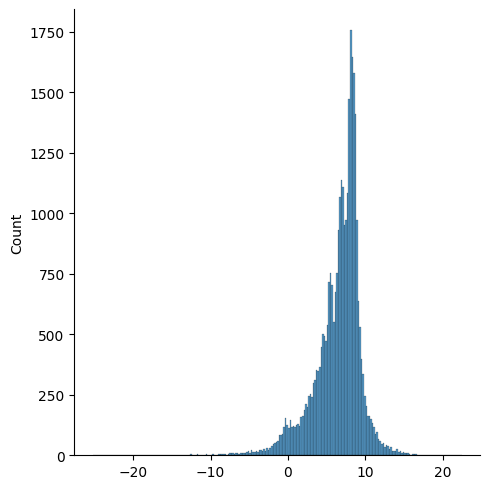

In [50]:
z = all_reps.reshape(all_reps.shape[0],-1)[:,138].numpy()
sns.displot(z)

<AxesSubplot: >

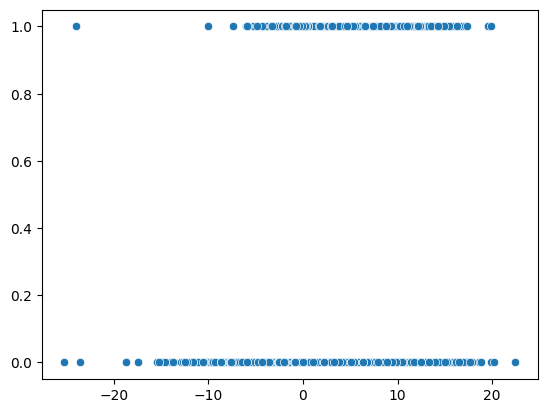

In [51]:
sns.scatterplot(x=z,y=y_train)

In [52]:
z.shape,y_train.shape

((32266,), (32266,))

In [53]:
np.arange(len(grids))[(grids -3.)<=0][-1]

NameError: name 'grids' is not defined

In [ ]:
X_train_raw[14][71,:][35]

In [ ]:
xi_t[34],x[:,34].max()

In [ ]:
torch.argsort(pred_y_train[:100],descending=True)

In [ ]:
pred_y_train[14],y_train[14]

In [ ]:
for zid in x_z_rules.keys():
    print(zid)
    sort_rules({zid:x_z_rules[zid]},input_feature_names,pos=(pred_y_train[tid]>0))

In [ ]:
def sort_rules(z_rules,input_feature_names,sort_by="cond_prob_y",pos=True,top=3):
    sorted_rules = []
    for zid, zr_dict in z_rules.items():
        new_zr = []
        print(zid,zr_dict['pos'])
        if zr_dict['pos']==pos:
            list_name = 'rule_dict_higher_z'
            p_thd = 'p(z>=thd_h)'
            thd = 'thd_h'
        else:
            list_name = 'rule_dict_lower_z'
            p_thd = 'p(z<=thd_l)'
            thd = 'thd_l'
        ## for dict with only one side    
        if list_name not in zr_dict.keys():
            if 'p(z>=thd_h)' in zr_dict.keys():
                list_name = 'rule_dict_higher_z'  
                p_thd = 'p(z>=thd_h)'
                thd = 'thd_h'
            else:
                list_name = 'rule_dict_lower_z'
                p_thd = 'p(z<=thd_l)'
                thd = 'thd_l'

        for path,rules_dict in zr_dict[list_name].items():
            #print(path,rules_dict)
            new_zrd = {}
            new_r = []
            for r in rules_dict["rules"]:
                new_r.append((r[0],input_feature_names[r[0]],r[1],r[2]))
            new_zrd["rules"] = new_r
            new_zrd['zid'] = zid
            new_zrd[p_thd]=zr_dict[p_thd]
            new_zrd[thd]=zr_dict[thd] 
            for f in ['cond_prob_y','cond_prob_z','support','ratio_y']:
                new_zrd[f] = rules_dict[f]

            new_zr.append(new_zrd)

            
        new_zr.sort(key=lambda x: x[sort_by], reverse=True)
        sorted_rules = sorted_rules + new_zr[:top]

    sorted_rules.sort(key=lambda x: x[sort_by], reverse=True)
    return sorted_rules

In [ ]:
pred_y_train[tid]

In [ ]:
zid = top_latent[0]
time_step= int(zid/latent_num)
latent_id = int(zid%latent_num)

z = all_reps[:,time_step,latent_id].numpy()
zi = z[tid]
zid,zi

In [ ]:
tz = all_reps[tid]
sort_zids = torch.argsort(torch.abs(tz.reshape(-1)*linear_prams[0]+linear_prams[1]))

In [ ]:
sort_zids[0][-1]

In [ ]:
match

In [ ]:
zid

In [ ]:
yi = y_train[tid]
yi

In [ ]:
match

In [ ]:
y_train.shape,z.shape

In [ ]:
if match is None:
    zw_pos = zw[zid]
    x_z_rules = find_pattern_by_sample_latent_state(xi,zi,x,y_train,z,itemsets[zid],zw_pos=zw_pos,c=1,num_grids=20,omega=0.1,min_support_pos=500,min_support_neg=2000,max_depth=5)

In [ ]:
x_z_rules

In [ ]:
x_z_rules = sort_rules({zid:x_z_rules},input_feature_names,pos=False)

In [ ]:
x_z_rules

In [79]:
g = np.linspace(1,100,100)

In [83]:
g[1]=1
g[2]=1


In [85]:
np.unique(g)

array([  1.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
        14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
        25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
        36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,
        47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,
        58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,
        69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,
        80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
        91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.])

In [86]:
g[99]

100.0